# SLC

## Imports

In [18]:
import os

import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 147006464
Cached GPU memory: 257949696


## Settings

In [ ]:

data_file = 'l1b'

N_PCA = 10        
TRAIN_SIZE = 0.8  
BATCH_SIZE = 16
EPOCH = 30        
LR = 0.0005       
WEIGHT_DECAY = 0.0001 
PATCH_SIZE = 32 
STRIDE = 16        
NUM_CLASS = 3      
VAL_EPOCH = 2     
VAL_RATE = 0.1     


RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 



random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

Number of bands utilized: 20
Training size: 0.8
Epochs: 50
Batch size: 32
Patch size: 48
Learning rate: 0.0005
Weight decay: 0.0001


## Dataset

In [20]:
raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'




raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    # 'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    # 'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    # 'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    # 'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    # 'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    # 'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    # 'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    # 'longisland_2024-06-25T14-52-40Z-l1b.nc',
    # 'longisland_2024-08-26T14-51-29Z-l1b.nc',
    # 'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    # 'marmara_2024-04-16T08-16-38Z-l1b.nc',
    # 'mvco_2025-03-02T14-55-47Z-l1b.nc',
    # 'nile_2024-11-02T07-51-59Z-l1b.nc',
    # 'plocan_2024-12-28T11-00-05Z-l1b.nc',
    # 'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    # 'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    # 'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    # 'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    # 'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    # 'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    'aegean_2024-08-22T08-41-46Z-l1d.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    'barbados_2025-03-04T13-54-23Z-l1d.nc',
    'capetown_2024-11-30T08-25-39Z-l1d.nc',
    'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    'dubai_2024-11-21T06-24-16Z-l1d.nc',
    'erie_2024-09-18T15-53-53Z-l1d.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    'florida_2024-05-21T15-51-31Z-l1d.nc',
    'florida_2024-05-30T15-34-21Z-l1d.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    'longisland_2024-06-25T14-52-40Z-l1d.nc',
    'longisland_2024-08-26T14-51-29Z-l1d.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    'marmara_2024-04-16T08-16-38Z-l1d.nc',
    'mvco_2025-03-02T14-55-47Z-l1d.nc',
    'nile_2024-11-02T07-51-59Z-l1d.nc',
    'plocan_2024-12-28T11-00-05Z-l1d.nc',
    'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    # 'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    # 'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    # 'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    # 'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    # 'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    # 'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    # 'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    # 'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    # 'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    # 'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    # 'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    # 'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    # 'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    # 'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    # 'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    # 'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    # 'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    # 'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    # 'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    # 'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    # 'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    # 'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    # 'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    # 'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    # 'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]

def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  


if data_file == 'l1a':
    l1a_files, l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
elif data_file == 'l1b':
    l1b_files, l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
elif data_file == 'l1d':
    l1d_files, l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")

# Load Labels and Keep Track of Filenames
labels = []
label_filenames = []
total_labels = len(labels_files)

with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
    for idx, filename in enumerate(labels_files, start=1):
        file_path = os.path.join(labels_path, filename)
        label = np.fromfile(file_path, dtype=np.uint8)
        label = label.reshape((598, 1092))
        labels.append(label)
        label_filenames.append(filename)  # Store filename

        pbar.set_postfix_str(f"Label {idx} / {total_labels}")
        pbar.update(1)

print(f"{data_file} data shape: {l1b_files[0].shape}")
print(f"Labels shape: {labels[0].shape}")
print(f"Filename: {l1b_filenames[0]}")
print(f"Labelname: {label_filenames[0]}")

Loading labels: 100%|██████████| 17/17 [00:00<00:00, 696.30file/s, Label 17 / 17]

l1b data shape: (598, 1092, 120)
Labels shape: (598, 1092)
Filename: adriatic_2024-07-18T08-53-45Z-l1b.nc
Labelname: adriatic_2024-07-18T08-53-45Z-l1a_labels.dat


## Plot Captures and Labels

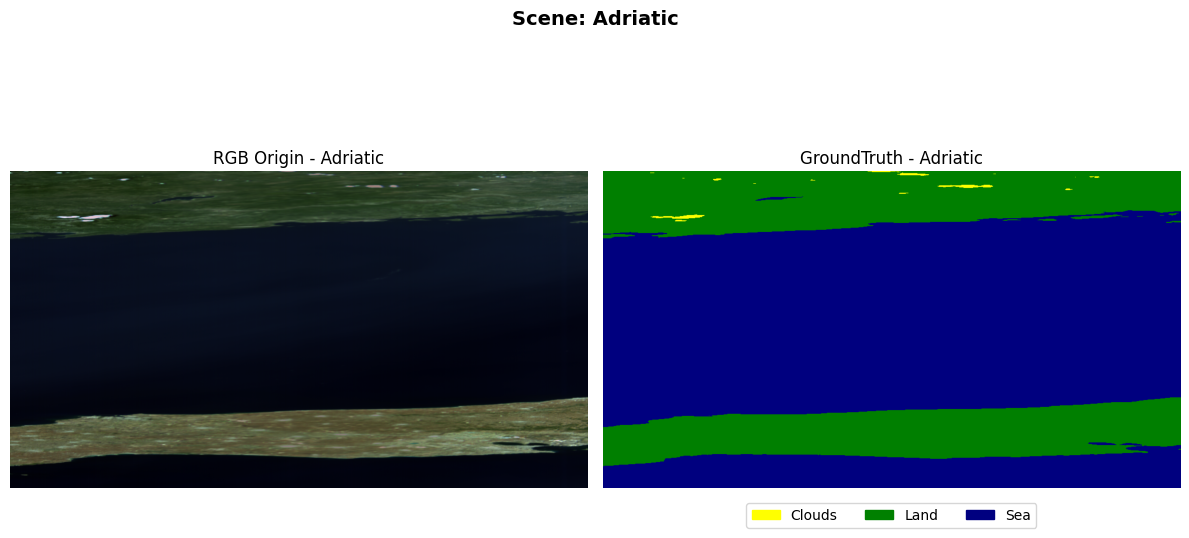

In [21]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]

# Add legend below GroundTruth
axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Pre-process data

### Dimensionality Reduction (PCA)

In [22]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)  
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [23]:
def extract_patches(image, patch_size=32, stride=16):

    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)

    return np.array(patches)  




class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=32, stride=16, is_pred=False):
   
        self.patches = []
        self.labels = []
        self.is_pred = is_pred

        for img_idx, img in enumerate(images):
            # Extract patches for the current image
            img_patches = extract_patches(img, patch_size, stride)

            # Add extracted patches
            self.patches.extend(img_patches)

            if not is_pred and labels is not None:
                # Extract corresponding patches for labels
                label_patches = extract_patches(labels[img_idx], patch_size, stride)
                self.labels.extend(label_patches)

        # Convert to PyTorch tensors
        self.patches = torch.tensor(self.patches, dtype=torch.float32).permute(0, 3, 1, 2)  # (B, C, H, W)
        if not is_pred and labels is not None:
            self.labels = torch.tensor(self.labels, dtype=torch.long)  # Assuming categorical labels

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        if self.is_pred:
            return self.patches[idx]  # No labels in prediction mode
        return self.patches[idx], self.labels[idx]
    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=32, stride=16):
        self.patches = []
        self.image_indices = []

        for img_idx, img in enumerate(images):
            img_patches = extract_patches(img, patch_size, stride)
            self.patches.extend(img_patches)
            self.image_indices.extend([img_idx] * len(img_patches))

        self.patches = torch.tensor(self.patches, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.image_indices[idx]
    

def reconstruct_image(patches, original_shape, patch_size=32, stride=16):

    H, W = original_shape  # ✅ Ensure (H, W) only
    reconstructed = np.zeros((H, W), dtype=np.uint16)  # ✅ Use `uint16` to avoid overflow
    count = np.zeros((H, W), dtype=np.uint16)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            reconstructed[i:i+patch_size, j:j+patch_size] += patches[patch_idx].astype(np.uint16)  # ✅ Convert dtype
            count[i:i+patch_size, j:j+patch_size] += 1
            patch_idx += 1


    return (reconstructed / np.maximum(count, 1)).astype(np.uint8)

## Apply Transformations

In [24]:
# Selected spectral bands to use before PCA
selected_bands = [110, 109, 111, 108, 113, 112, 107, 102, 101, 100, 99, 106, 98, 103, 97, 96,
                            81, 80, 79, 78, 77, 76, 75, 74, 82, 85, 73, 86, 84, 95, 88, 87, 72, 89, 71,
                            70, 69, 90, 83, 68, 67, 93, 64, 66, 94, 65, 63, 62, 61, 60, 59, 9, 58, 91,
                            105, 57, 10, 54, 55, 56, 92, 53, 52, 51, 11, 12, 50, 49, 48, 47, 13, 46,
                            14, 6, 4, 45, 3, 5, 7, 34, 8, 15, 16, 25, 44, 33, 43, 35, 40, 36, 17, 41,
                            42, 37, 29, 39, 32, 38, 26, 20, 19, 18, 27, 28, 30, 24, 31, 21, 23, 22, 104]

num_pca_components = N_PCA


pca_processed_images = []

if data_file == 'l1a':
    files = l1a_files
elif data_file == 'l1b':
    files = l1b_files
elif data_file == 'l1d':
    files = l1d_files





total_images = len(files)
with tqdm(total=total_images, desc="Processing PCA for images", unit="image") as pbar:
    for idx, img in enumerate(files, start=1):
        # Extract only the selected bands
        filtered_data = img[:, :, selected_bands]  # Shape: (H, W, len(selected_bands))

        # Flatten for PCA: Reshape to (pixels, bands)
        reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])

        # Apply PCA to reduce the number of bands
     
        pca = PCA(n_components=num_pca_components)
        pca_data = pca.fit_transform(reshaped_data)

        # Reshape back to (H, W, PCA components)
        pca_data = pca_data.reshape(img.shape[0], img.shape[1], num_pca_components)

        # ✅ Append EACH processed image inside the loop
        pca_processed_images.append(pca_data)

        # Update progress bar
        pbar.set_postfix_str(f"Image {idx} / {total_images}")
        pbar.update(1)

# Convert to numpy array (after all images are processed)
pca_processed_images = np.array(pca_processed_images)  # Should have shape (43, 598, 1092, num_pca_components)

processed_images = list(pca_processed_images)



if data_file == 'l1a':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  
elif data_file == 'l1b':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  
elif data_file == 'l1d':
    print(f"Processed {data_file} shape: {np.array(processed_images).shape}")  





Processing PCA for images: 100%|██████████| 17/17 [00:12<00:00,  1.37image/s, Image 17 / 17]


Processed l1b shape: (17, 598, 1092, 20)


## Data Split

In [25]:
(training_files, testing_files, 
 training_labels, testing_labels, 
 training_filenames, testing_filenames, 
 training_label_filenames, testing_label_filenames) = train_test_split(
    processed_images, labels, l1b_filenames, label_filenames, 
    test_size=1 - TRAIN_SIZE, random_state=42
)

VALIDATION_SIZE = 0.2

(train_images, val_images, 
 train_labels, val_labels, 
 train_filenames, val_filenames, 
 train_label_filenames, val_label_filenames) = train_test_split(
    training_files, training_labels, training_filenames, training_label_filenames,
    test_size=VALIDATION_SIZE, random_state=42
)


## Patching

## Create dataset and dataloader

In [ ]:

train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)
test_data = TestPatchSet(testing_files, PATCH_SIZE, STRIDE)


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Training & validation DataLoaders ready. No memory overload!")



## Model

In [ ]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks with the same channel progression as the classification model
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        for i in range(levels):
            # Keep the same channel calculation logic from the classification model
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Replace global pooling and FC layer with segmentation head
        total_channels = sum(64 * (i + 1) for i in range(levels))
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(total_channels // 2, class_nums, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[2:]  # Store original input size
        features = []
        low_pass = x
        
        # Wavelet processing (same as before)
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)
            
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]
            
            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)
        
        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)
        
        # Upscale back to input size for segmentation
        out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
        return out


In [ ]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)



Input tensor shape: torch.Size([1, 10, 32, 32])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 10, 32, 32]    [1, 3, 32, 32]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 10, 32, 32]    [1, 10, 16, 16]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        2,624              [1, 1]             671,744            [1, 40, 16, 16]    [1, 64, 16, 16]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 16, 16

## Training

Using device: cuda


Training::   3%|▎         | 1/30 [00:11<05:30, 11.40s/it]

epoch 0/30 loss:1.7330690558146353e-05  acc:0.8951549624922264


100%|██████████| 1508/1508 [00:10<00:00, 141.98it/s]


epoch 1/30 loss:1.142187741208717e-05  acc:0.9339683823719942


Training::   7%|▋         | 2/30 [00:24<05:46, 12.38s/it]

epoch 1/30  val_acc:0.7960898092005252
Epoch 2/30 completed in 13.06 seconds.


Training::  10%|█         | 3/30 [00:35<05:11, 11.55s/it]

epoch 2/30 loss:1.0004862626033362e-05  acc:0.9411777781016791


100%|██████████| 1508/1508 [00:10<00:00, 143.36it/s]


epoch 3/30 loss:9.536536398624487e-06  acc:0.9430741798818408


Training::  13%|█▎        | 4/30 [00:48<05:15, 12.14s/it]

epoch 3/30  val_acc:0.7633879215035931
Epoch 4/30 completed in 13.05 seconds.


Training::  17%|█▋        | 5/30 [00:58<04:50, 11.61s/it]

epoch 4/30 loss:9.034950233679826e-06  acc:0.945660774901534


100%|██████████| 1508/1508 [00:10<00:00, 142.26it/s]


epoch 5/30 loss:8.560591809999075e-06  acc:0.9478218040656095


Training::  20%|██        | 6/30 [01:11<04:50, 12.09s/it]

epoch 5/30  val_acc:0.7323260541908513
Epoch 6/30 completed in 13.02 seconds.


Training::  23%|██▎       | 7/30 [01:22<04:26, 11.58s/it]

epoch 6/30 loss:8.565288922460062e-06  acc:0.9475836961028192


100%|██████████| 1508/1508 [00:10<00:00, 141.30it/s]


epoch 7/30 loss:8.11652426863404e-06  acc:0.9499718205845771


Training::  27%|██▋       | 8/30 [01:35<04:25, 12.06s/it]

epoch 7/30  val_acc:0.7117015022543532
Epoch 8/30 completed in 13.10 seconds.


Training::  30%|███       | 9/30 [01:46<04:03, 11.61s/it]

epoch 8/30 loss:8.023123364122207e-06  acc:0.9501837330275705


100%|██████████| 1508/1508 [00:10<00:00, 141.67it/s]


epoch 9/30 loss:7.930616588301123e-06  acc:0.9504477126088309


Training::  33%|███▎      | 10/30 [01:59<04:01, 12.09s/it]

epoch 9/30  val_acc:0.7430533962133775
Epoch 10/30 completed in 13.16 seconds.


Training::  37%|███▋      | 11/30 [02:09<03:40, 11.60s/it]

epoch 10/30 loss:7.640889712028655e-06  acc:0.9518187869247512


100%|██████████| 1508/1508 [00:10<00:00, 144.17it/s]


epoch 11/30 loss:7.849196611708263e-06  acc:0.9507022585639511


Training::  40%|████      | 12/30 [02:22<03:35, 11.99s/it]

epoch 11/30  val_acc:0.7517788930780127
Epoch 12/30 completed in 12.89 seconds.


Training::  43%|████▎     | 13/30 [02:33<03:16, 11.58s/it]

epoch 12/30 loss:7.402285929017984e-06  acc:0.9530019579835199


100%|██████████| 1508/1508 [00:10<00:00, 143.88it/s]


epoch 13/30 loss:7.426655591656237e-06  acc:0.9526632786587894


Training::  47%|████▋     | 14/30 [02:46<03:11, 11.97s/it]

epoch 13/30  val_acc:0.7172082296849088
Epoch 14/30 completed in 12.88 seconds.


Training::  50%|█████     | 15/30 [02:56<02:53, 11.55s/it]

epoch 14/30 loss:7.314184733890227e-06  acc:0.9534333135753524


100%|██████████| 1508/1508 [00:10<00:00, 140.90it/s]


epoch 15/30 loss:7.1873632457327415e-06  acc:0.9540713587012852


Training::  53%|█████▎    | 16/30 [03:09<02:48, 12.04s/it]

epoch 15/30  val_acc:0.7767681503506771
Epoch 16/30 completed in 13.16 seconds.


Training::  57%|█████▋    | 17/30 [03:20<02:31, 11.62s/it]

epoch 16/30 loss:7.139135326781814e-06  acc:0.9544352618418325


100%|██████████| 1508/1508 [00:10<00:00, 142.84it/s]


epoch 17/30 loss:7.335347071456579e-06  acc:0.9532737111966211


Training::  60%|██████    | 18/30 [03:33<02:24, 12.04s/it]

epoch 17/30  val_acc:0.7597572575490602
Epoch 18/30 completed in 13.02 seconds.


Training::  63%|██████▎   | 19/30 [03:43<02:07, 11.59s/it]

epoch 18/30 loss:7.013838408595683e-06  acc:0.95461377196051


100%|██████████| 1508/1508 [00:10<00:00, 141.58it/s]


epoch 19/30 loss:6.9819776370115225e-06  acc:0.9550741167210821


Training::  67%|██████▋   | 20/30 [03:57<02:00, 12.04s/it]

epoch 19/30  val_acc:0.7784626941248618
Epoch 20/30 completed in 13.08 seconds.


Training::  70%|███████   | 21/30 [04:07<01:44, 11.59s/it]

epoch 20/30 loss:7.085558955535647e-06  acc:0.9540471875647802


100%|██████████| 1508/1508 [00:10<00:00, 144.14it/s]


epoch 21/30 loss:6.8418105135770715e-06  acc:0.9555925207944652


Training::  73%|███████▎  | 22/30 [04:20<01:35, 11.99s/it]

epoch 21/30  val_acc:0.7636980570239082
Epoch 22/30 completed in 12.94 seconds.


Training::  77%|███████▋  | 23/30 [04:31<01:21, 11.58s/it]

epoch 22/30 loss:6.954725672834349e-06  acc:0.954932652816646


100%|██████████| 1508/1508 [00:10<00:00, 141.18it/s]


epoch 23/30 loss:6.886582049760311e-06  acc:0.9555066059675581


Training::  80%|████████  | 24/30 [04:44<01:12, 12.06s/it]

epoch 23/30  val_acc:0.7983019203029988
Epoch 24/30 completed in 13.17 seconds.


Training::  83%|████████▎ | 25/30 [04:55<00:58, 11.64s/it]

epoch 24/30 loss:6.9039183346682555e-06  acc:0.9552212084110696


100%|██████████| 1508/1508 [00:10<00:00, 142.02it/s]


epoch 25/30 loss:6.822699457384041e-06  acc:0.9554559154099295


Training::  87%|████████▋ | 26/30 [05:08<00:48, 12.09s/it]

epoch 25/30  val_acc:0.7618261772733554
Epoch 26/30 completed in 13.12 seconds.


Training::  90%|█████████ | 27/30 [05:18<00:34, 11.66s/it]

epoch 26/30 loss:6.8212487866381035e-06  acc:0.9555592804208126


100%|██████████| 1508/1508 [00:10<00:00, 141.15it/s]


epoch 27/30 loss:6.682662036698666e-06  acc:0.9562411736888474


Training::  93%|█████████▎| 28/30 [05:31<00:24, 12.12s/it]

epoch 27/30  val_acc:0.7617268475331676
Epoch 28/30 completed in 13.17 seconds.


Training::  97%|█████████▋| 29/30 [05:42<00:11, 11.69s/it]

epoch 28/30 loss:6.84880351820786e-06  acc:0.9556677468775913


100%|██████████| 1508/1508 [00:10<00:00, 141.80it/s]


epoch 29/30 loss:6.688629900134305e-06  acc:0.9561046492796434


Training:: 100%|██████████| 30/30 [05:55<00:00, 11.86s/it]


epoch 29/30  val_acc:0.7838629389942647
Epoch 30/30 completed in 13.12 seconds.
Training completed in 355.83 seconds.
Stop in epoch 29


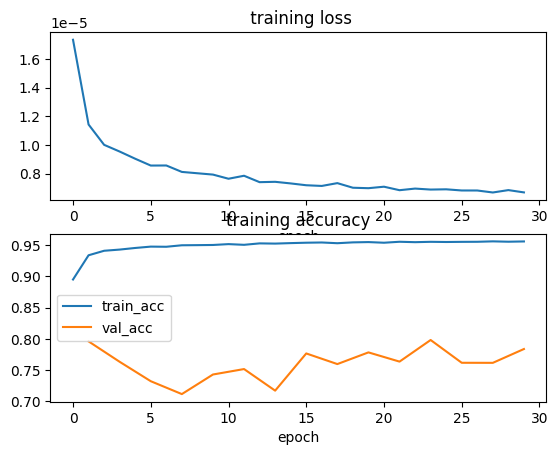

In [ ]:


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
#optimizer = torch.optim.SGD(model.parameters(), LR,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE
val_num = val_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

e = -1


start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)


            epoch_end_time = time.time()
            print(f"Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")



    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title(' training loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('training accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    print(f'Stop in epoch {e}')

### Save Best Model

In [ ]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

best model:epoch_23_acc_0.7983.pth
✅ Loading Best Model from: results\l1b\epoch_23_acc_0.7983.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/4 - Scene: adriatic_2024-07-18T08-53-45Z
Unique classes in ground truth before plotting: [1 2 3]


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_16860\40373799.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_

Unique classes in prediction before plotting: [0 1 2]


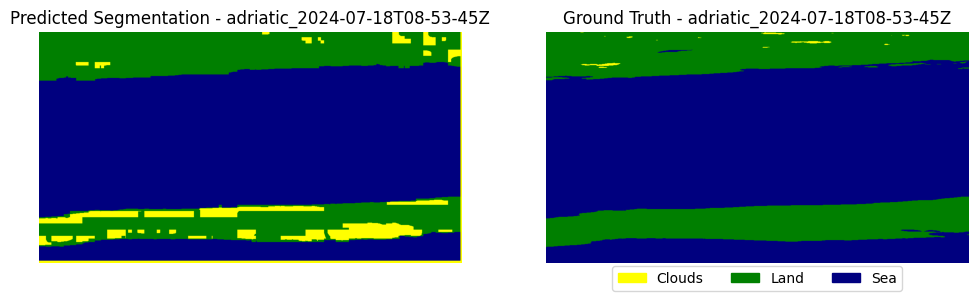


Processing Test Image 2/4 - Scene: aegean_2024-08-22T08-41-46Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2: 100%|██████████| 19/19 [00:01<00:00, 16.90it/s]


Unique classes in prediction before plotting: [0 1 2]


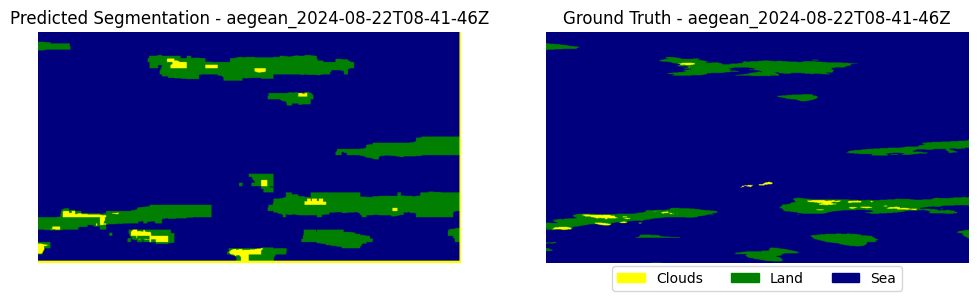


Processing Test Image 3/4 - Scene: barbados_2025-03-04T13-54-23Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3: 100%|██████████| 19/19 [00:01<00:00, 16.99it/s]


Unique classes in prediction before plotting: [0 1 2]


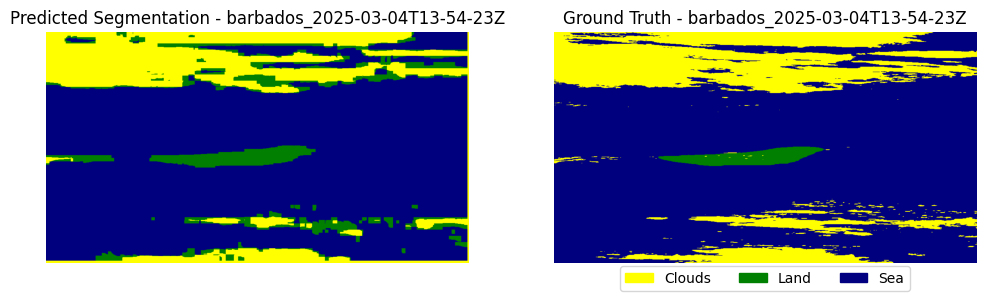


Processing Test Image 4/4 - Scene: fredrikstad_2024-09-10T09-54-25Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4: 100%|██████████| 19/19 [00:01<00:00, 17.58it/s]


Unique classes in prediction before plotting: [0 1 2]


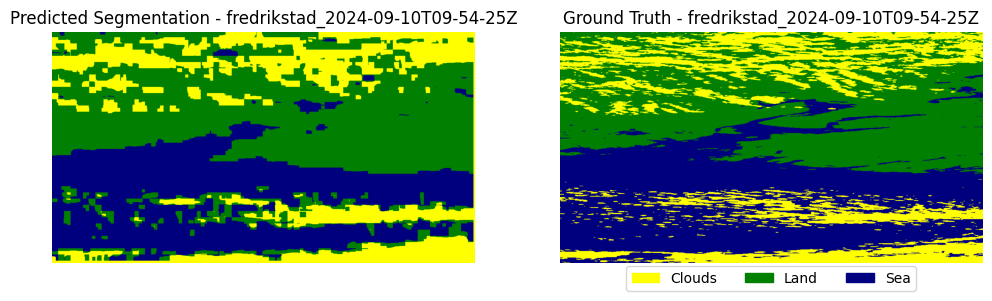

In [ ]:

import os
import spectral
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define class names and color map (same as original ground truth)
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert dictionary to a ListedColormap for Matplotlib
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# ✅ Pre-load the correct ground truth labels for the test files
testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(label_filenames, labels)
}

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")


# ✅ Process each test image separately
for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label


    # ✅ Ensure Ground Truth is Unmodified
    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    # ✅ Get the test image data
    test_img = testing_files[img_idx]

    # Create dataset and DataLoader for the current test image
    test_data = TestPatchSet([test_img], patch_size=32, stride=16)
    test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

    ## Initialize storage for predicted patches
    pred_patches = []

    # Process all patches for this test image
    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)  

        # Get model predictions
        out = best_model(data)
        _, pred = torch.max(out, dim=1)  # Get class predictions

        # Convert to numpy and store
        pred_patches.append(pred.detach().cpu().numpy())

    ## Convert predictions into a single array
    pred_patches = np.concatenate(pred_patches, axis=0)

    ## Reconstruct the predicted segmentation map
    original_shape = test_img.shape[:2]  # Extract (H, W) only
    pred_map = reconstruct_image(pred_patches, original_shape, patch_size=32, stride=16)

    ## ✅ Ensure Predictions Contain All Expected Classes
    print(f"Unique classes in prediction before plotting: {np.unique(pred_map)}")

    ## ✅ Create Side-by-Side Comparison Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show prediction
    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Predicted Segmentation - {scene_name}')
    axes[0].axis("off")  

    # Show ground truth
    axes[1].imshow(ground_truth, cmap=custom_cmap)  # ✅ No reshaping, directly plots as loaded
    axes[1].set_title(f'Ground Truth - {scene_name}')
    axes[1].axis("off")  

    # ✅ Create legend
    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

    # ✅ Show the plot
    plt.show()


## Evaluation

In [ ]:
all_true_labels = []
all_pred_labels = []
eval_results = []

for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label

    ## ✅ Extract valid pixels (ignore background pixels where ground truth is 0)
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    ## ✅ Compute metrics for this individual image
    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)

    unique_classes = np.unique(test_true)

    # ✅ Ensure only present classes are used in target_names
    target_names = [class_names[c] for c in unique_classes if c in class_names]

    # ✅ Compute classification report with dynamically detected classes
    class_report = classification_report(test_true, test_pred, labels=unique_classes, target_names=target_names, digits=4, zero_division=0)


    # ✅ Store the individual results
    eval_results.append({
        "Scene": scene_name,
        "Overall Accuracy": round(OA, 4),
        "Average Accuracy": round(AA, 4),
        "Kappa Score": round(kappa, 4),
        "Classification Report": class_report
    })

    ## ✅ Append results for total evaluation
    all_true_labels.extend(test_true)
    all_pred_labels.extend(test_pred)

    ## ✅ Print individual report
    print(f"\n📌 Evaluation for {scene_name}:")
    print(f"OA: {OA:.4f} | AA: {AA:.4f} | Kappa: {kappa:.4f}")
    print(class_report)
    print("-" * 80)



## ✅ Convert lists to NumPy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

## ✅ Compute overall metrics
OA_total = accuracy_score(all_true_labels, all_pred_labels)
AA_total = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
kappa_total = cohen_kappa_score(all_true_labels, all_pred_labels)
# ✅ Dynamically get unique class values
unique_classes_overall = np.unique(all_true_labels)

# ✅ Ensure only present classes are used in target_names
target_names_overall = [class_names[c] for c in unique_classes_overall if c in class_names]

# ✅ Compute classification report with dynamically detected classes
overall_class_report = classification_report(all_true_labels, all_pred_labels, labels=unique_classes_overall, target_names=target_names_overall, digits=4, zero_division=0)

## ✅ Store final evaluation
eval_results.append({
    "Scene": "Overall",
    "Overall Accuracy": round(OA_total, 4),
    "Average Accuracy": round(AA_total, 4),
    "Kappa Score": round(kappa_total, 4),
    "Classification Report": overall_class_report
})

## ✅ Print overall report
print("\n📊 Overall Evaluation Across All Predicted Images:")
print(f"Overall Accuracy: {OA_total:.4f} | Average Accuracy: {AA_total:.4f} | Kappa: {kappa_total:.4f}")
print(overall_class_report)







Processing Test Image 1/4 - Scene: adriatic_2024-07-18T08-53-45Z

📌 Evaluation for adriatic_2024-07-18T08-53-45Z:
OA: 0.0876 | AA: 0.2233 | Kappa: -0.0129
              precision    recall  f1-score   support

      Clouds     0.0028    0.6132    0.0056      1360
        Land     0.2710    0.2798    0.2754    201405
         Sea     0.0000    0.0000    0.0000    450251

   micro avg     0.1130    0.0876    0.0987    653016
   macro avg     0.0913    0.2977    0.0936    653016
weighted avg     0.0836    0.0876    0.0849    653016

--------------------------------------------------------------------------------

Processing Test Image 2/4 - Scene: aegean_2024-08-22T08-41-46Z

📌 Evaluation for aegean_2024-08-22T08-41-46Z:
OA: 0.0268 | AA: 0.1335 | Kappa: 0.0003
              precision    recall  f1-score   support

      Clouds     0.0019    0.1958    0.0039      2967
        Land     0.0813    0.3382    0.1311     50020
         Sea     0.0000    0.0000    0.0000    600029

   micro avg 